# HW3 Practical: Comparing Generative Paradigms on CIFAR-10


Welcome! This notebook provides the training and evaluation pipeline for the four generative models you will build in `models/`.

- Run the setup cells to install dependencies and load CIFAR-10.
- Complete the TODOs in the Python modules, verify with Gradescope autograder, then return here to train and evaluate models.
- Follow the prompts in each section to log results and save artefacts (sample image grids, metrics, and plots) for inclusion in your PDF report.


In [67]:
# Install lightweight dependencies (safe to re-run)
%pip install --quiet torch-fidelity tqdm


Note: you may need to restart the kernel to use updated packages.


In [68]:
import math
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

from cifar10 import load_cifar10
from models.gan import DCGAN
from models.vae import ConvVAE
from models.pixelcnn import PixelCNN
from models.ddpm import DenoiseUNet

from torch_fidelity import calculate_metrics

In [69]:
# Global configuration
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 32
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
print(f"Project root: {PROJECT_ROOT}")


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti
Project root: c:\Users\sidne\OneDrive\Bureau\Automne2025\school\Representationh_L-IFT6135\homeworks\hw3\part1


### Experiment presets

The dictionaries below define the baseline ("small") and scaled ("medium") configurations used in the assignment. Baselines train for 30 epochs, and the scaled variants run for 40 epochs so you can contrast added capacity with extra compute. Feel free to explore other values.


In [70]:
EXPERIMENT_CONFIGS = {
    "dcgan": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 128, "epochs": 40, "lr": 2e-4},
    },
    "vae": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 192, "epochs": 40, "lr": 2e-4},
    },
    "pixelcnn": {
        "small": {"hidden_channels": 64, "residual_layers": 5, "epochs": 30, "lr": 3e-4},
        "medium": {"hidden_channels": 96, "residual_layers": 7, "epochs": 40, "lr": 3e-4},
    },
    "ddpm": {
        "small": {"base_channels": 64, "time_channels": 256, "timesteps": 1000, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "time_channels": 256, "timesteps": 750, "epochs": 40, "lr": 2e-4},
    },
}

EXPERIMENT_CONFIGS


{'dcgan': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 128,
   'epochs': 40,
   'lr': 0.0002}},
 'vae': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 192,
   'epochs': 40,
   'lr': 0.0002}},
 'pixelcnn': {'small': {'hidden_channels': 64,
   'residual_layers': 5,
   'epochs': 30,
   'lr': 0.0003},
  'medium': {'hidden_channels': 96,
   'residual_layers': 7,
   'epochs': 40,
   'lr': 0.0003}},
 'ddpm': {'small': {'base_channels': 64,
   'time_channels': 256,
   'timesteps': 1000,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'time_channels': 256,
   'timesteps': 750,
   'epochs': 40,
   'lr': 0.0002}}}

In [71]:
THROUGHPUT_SAMPLES = {
    "dcgan": 1024,
    "vae": 1024,
    "pixelcnn": 1024,  # autoregressive sampling is slow; document your actual sample count if you change this
    "ddpm": 1024,
}

THROUGHPUT_SAMPLES


{'dcgan': 1024, 'vae': 1024, 'pixelcnn': 1024, 'ddpm': 1024}

## Data loading


In [72]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


In [73]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


## Utility functions


In [74]:
from torch.utils.data import Dataset


    
def to_device(batch, device=DEVICE):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}


def images_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor.detach().cpu().clamp(0.0, 1.0)
    tensor = (tensor * 255.0).round().to(torch.uint8)
    return tensor.permute(0, 2, 3, 1).numpy()


def save_image_grid(images: torch.Tensor, path: Path, nrow: int = 8):
    path.parent.mkdir(parents=True, exist_ok=True)
    grid = make_grid(images.detach().cpu(), nrow=nrow, padding=2)
    save_image(grid, str(path))
    return grid


def gather_real_images(loader: DataLoader, max_samples: int = 2048) -> torch.Tensor:
    batches = []
    total = 0
    for batch in loader:
        imgs = batch["images"]
        batches.append(imgs)
        total += imgs.size(0)
        if total >= max_samples:
            break
    return torch.cat(batches, dim=0)[:max_samples]

class _ArrayDataset(Dataset):
    def __init__(self, array: np.ndarray):
        self.array = array
    def __len__(self) -> int:
        return self.array.shape[0]
    def __getitem__(self, idx: int):
        arr = self.array[idx]
        tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
        return tensor
        
def compute_kid_score(real_images: torch.Tensor, fake_images: torch.Tensor) -> float:
    real_np = images_to_uint8(real_images)
    fake_np = images_to_uint8(fake_images)


    metrics = calculate_metrics(
        input1=_ArrayDataset(fake_np),
        input2=_ArrayDataset(real_np),
        kid=True,
        fid=False,
        verbose=True,
        ProgressBar=True,
        cuda=True,
        show_progress_bar=True,
        save_cpu_ram=True
    )
    kid_key = "kernel_inception_distance_mean"
    if kid_key not in metrics:
        kid_key = "kid_mean"
    kid_value = metrics.get(kid_key)
    if kid_value is None:
        raise KeyError(f"KID metric missing expected keys: {list(metrics.keys())}")
    return float(kid_value)




def measure_sampling_throughput(sample_fn, num_images: int = 1024, device=DEVICE):
    torch.cuda.empty_cache()
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.perf_counter()
    samples = sample_fn(num_images=num_images, device=device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    elapsed = time.perf_counter() - start
    throughput = num_images / elapsed
    return samples, elapsed, throughput


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [75]:
real_subset = gather_real_images(val_loader, max_samples=2048)
real_subset_device = real_subset.to(DEVICE)
print(f"Real subset cached: {real_subset.shape} (device copy: {real_subset_device.shape})")



Real subset cached: torch.Size([2048, 3, 32, 32]) (device copy: torch.Size([2048, 3, 32, 32]))


## Training loops


In [76]:
def _init_history():
    return defaultdict(list)
  
def train_dcgan(model: DCGAN, dataloader: DataLoader, optimizer_g, optimizer_d, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)

            model.zero_grad(set_to_none=True)
            optimizer_d.zero_grad(set_to_none=True)
            out_d = model({"images": images})
            loss_d = out_d["discriminator_loss"]
            loss_d.backward()
            optimizer_d.step()

            model.zero_grad(set_to_none=True)
            optimizer_g.zero_grad(set_to_none=True)
            out_g = model({"images": images})
            loss_g = out_g["generator_loss"]
            loss_g.backward()
            optimizer_g.step()

            history["d_loss"].append(loss_d.item())
            history["g_loss"].append(loss_g.item())
            progress.set_postfix({"d": loss_d.item(), "g": loss_g.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_vae(model: ConvVAE, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[VAE] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            history["kl"].append(out["kl"].mean().item())
            history["recon"].append(out["reconstruction_loss"].mean().item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_pixelcnn(model: PixelCNN, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[PixelCNN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_ddpm(model: DenoiseUNet, dataloader: DataLoader, optimizer, epochs: int = 1, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DDPM] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history



## Sampling & evaluation helper functions


In [77]:
@torch.no_grad()
def sample_dcgan(model: DCGAN, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        fake = model.sample(z)### TODO: sample from the model
        samples.append(fake.detach().cpu())
    return torch.cat(samples, dim=0)


@torch.no_grad()
def sample_vae(model: ConvVAE, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        mean, logvar = model.decode(z) ### TODO: decode the latent codes using the model
        std = torch.exp(0.5 * logvar)
        draw = mean + std * torch.randn_like(std) ### TODO: sample from the distribution
        samples.append(draw.detach().cpu())
    return torch.cat(samples, dim=0).clamp(0.0, 1.0)


@torch.no_grad()
def sample_pixelcnn(model: PixelCNN, num_samples: int = 16, device=DEVICE, image_size: int = IMAGE_SIZE):
    model.eval()
    model.to(device)
    bins = model.bins
    samples = torch.zeros(num_samples, model.image_channels, image_size, image_size, device=device)
    for row in range(image_size):
        for col in range(image_size):
            logits = model({"images": samples})["logits"] ### TODO get the logits from the model
            logits = logits.view(num_samples, model.image_channels, bins, image_size, image_size)
            pixel_logits = logits[:, :, :, row, col]
            probs = torch.softmax(pixel_logits, dim=2) ### TODO: Softmax the logits to get the probability of each bin
            cat = torch.distributions.Categorical(probs=probs)
            pixel = cat.sample()
            pixel = pixel.float() / (bins - 1)
            samples[:, :, row, col] = pixel
    return samples.detach().cpu().clamp(0.0, 1.0)


@torch.no_grad()
def _ddpm_predict_noise(model: DenoiseUNet, xt: torch.Tensor, t: torch.Tensor):
    time_emb = model.time_embedding(t)
    h0 = model.model["init"](xt)#input_blocks[0](xt, time_emb) ### TODO: forward the input through the layers
    skip0, h1 = model.model["down0"](h0, time_emb) ### TODO
    skip1, h2 = model.model["down1"](h1, time_emb) ### TODO
    skip2, h3 = model.model["down2"](h2, time_emb) ### TODO
    h_mid = model.model["mid"](h3, time_emb) ### TODO
    h = model.model["up2"](h_mid, skip2, time_emb) ### TODO
    h = model.model["up1"](h, skip1, time_emb) ### TODO
    h = model.model["up0"](h, skip0, time_emb) ### TODO
    pred_noise = model.model["out"](h) ### TODO
    return pred_noise


@torch.no_grad()
def sample_ddpm(model: DenoiseUNet, num_samples: int = 64, device=DEVICE, timesteps: int = None):
    model.eval()
    model.to(device)
    T = timesteps if timesteps is not None else model.timesteps
    betas = model.betas.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = model.alphas_cumprod.to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    xt = torch.randn(num_samples, model.image_channels, IMAGE_SIZE, IMAGE_SIZE, device=device)
    for step in reversed(range(T)):
        t = torch.full((num_samples,), step, device=device, dtype=torch.long)
        pred_noise = _ddpm_predict_noise(model, xt, t) ### TODO: predict the noise from the model
        beta_t = betas[step]
        sqrt_recip_alpha_t = sqrt_recip_alphas[step]
        sqrt_one_minus_cumprod_t = sqrt_one_minus_cumprod[step]
        model_mean = sqrt_recip_alpha_t * (xt - beta_t / sqrt_one_minus_cumprod_t * pred_noise)
        if step > 0:
            variance = beta_t * (1.0 - alphas_cumprod_prev[step]) / (1.0 - alphas_cumprod[step])
            noise = torch.randn_like(xt)
            xt = model_mean + torch.sqrt(variance) * noise ### TODO: update the image
        else:
            xt = model_mean
    return xt.detach().cpu().clamp(-1.0, 1.0)



## Experiment tracking utilities


In [78]:
experiment_log = {}


def record_metrics(model_name: str, variant: str, metrics: dict):
    experiment_log.setdefault(model_name, {})[variant] = metrics


def show_metrics(model_name: str = None):
    if model_name is None:
        for name in experiment_log:
            show_metrics(name)
        return
    print(f"=== {model_name} ===")
    entries = experiment_log.get(model_name, {})
    for variant, metrics in entries.items():
        print(f"  [{variant}]")
        for key, value in metrics.items():
            print(f"    {key}: {value}")
    if not entries:
        print("  (no entries yet)")


## DCGAN (adversarial generation)

Fill in the TODOs inside `models/gan.py` before running this section. The cells below:

1. Instantiate the model and optimizers.
2. Train for the baseline configuration.
3. Generate sample grids, measure KID, and record sampling throughput.
4. Repeat with the medium-scale variant


In [79]:
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["small"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Baseline DCGAN parameters: {count_parameters(dcgan):,}")


Baseline DCGAN parameters: 1,846,980


In [80]:
DCGAN_EPOCHS = dcgan_cfg["epochs"]

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")


Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [7.82, 7.83, 7.54, 7.67, 7.66, 7.76, 7.81, 7.73, 7.72, 7.79, 7.49, 7.63, 7.6, 7.58, 7.41, 7.67, 7.65, 7.54, 7.62, 7.79, 8.02, 7.85, 7.9, 7.94, 7.76, 7.82, 8.02, 7.85, 7.72, 7.79]


In [81]:
# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "baseline",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.058
Sampling time for 1024 images: 0.02 s (throughput 55794.1 img/s)


Kernel Inception Distance: 0.05819546461105347 ± 0.0002284334466033065


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DCGAN", "scaled-30ep", {...})` / `"scaled-40ep"`).


## Convolutional VAE (latent variable model)

Make sure the loss components in `models/vae.py` are implemented before training.


In [82]:
vae_cfg = EXPERIMENT_CONFIGS["vae"]["small"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Baseline VAE parameters: {count_parameters(vae):,}")


Baseline VAE parameters: 3,518,214


In [83]:
VAE_EPOCHS = vae_cfg["epochs"]

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")


Finished VAE training: 11730 steps
VAE training time per epoch (s): [5.75, 5.89, 5.87, 5.67, 5.66, 5.52, 5.49, 5.45, 5.42, 5.45, 5.43, 5.57, 5.58, 5.85, 5.97, 5.76, 5.94, 5.93, 5.85, 5.8, 5.48, 5.71, 5.77, 5.89, 5.86, 5.99, 5.81, 5.81, 5.66, 5.82]


In [84]:
def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "baseline",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation ELBO: -3616.7399 (recon -3855.5229, KL 238.7829)
KID (x10^3): 0.293
Sampling time for 1024 images: 0.02 s (throughput 46293.2 img/s)


Kernel Inception Distance: 0.2933098030090332 ± 0.0005429790599981254


> **Scaling experiment:** Retrain the medium-scale configuration and log metrics after 30 and 40 epochs (e.g. `record_metrics("VAE", "scaled-30ep", {...})` / `"scaled-40ep"`).


## PixelCNN (autoregressive generation)

Ensure the masking logic and loss in `models/pixelcnn.py` are implemented.


In [85]:
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["small"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Baseline PixelCNN parameters: {count_parameters(pixelcnn):,}")


Baseline PixelCNN parameters: 268,992


In [86]:
PIXELCNN_EPOCHS = pixelcnn_cfg["epochs"]

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")


Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [17.7, 17.99, 18.08, 17.69, 17.78, 17.79, 17.5, 17.71, 17.46, 17.72, 17.69, 17.69, 17.72, 17.74, 17.59, 17.65, 17.79, 17.32, 17.21, 17.91, 18.81, 18.5, 18.36, 18.32, 18.04, 17.66, 17.9, 17.54, 17.51, 17.65]


In [87]:
def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_baseline.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "baseline",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

Validation NLL: 3.8219
KID (x10^3): 0.161
Sampling time for 1024 images: 541.54 s (throughput 1.89 img/s)


Kernel Inception Distance: 0.161173038482666 ± 0.0004256044615210478


> **Scaling experiment:** > **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("PixelCNN", "scaled-30ep", {...})` / `"scaled-40ep"`).


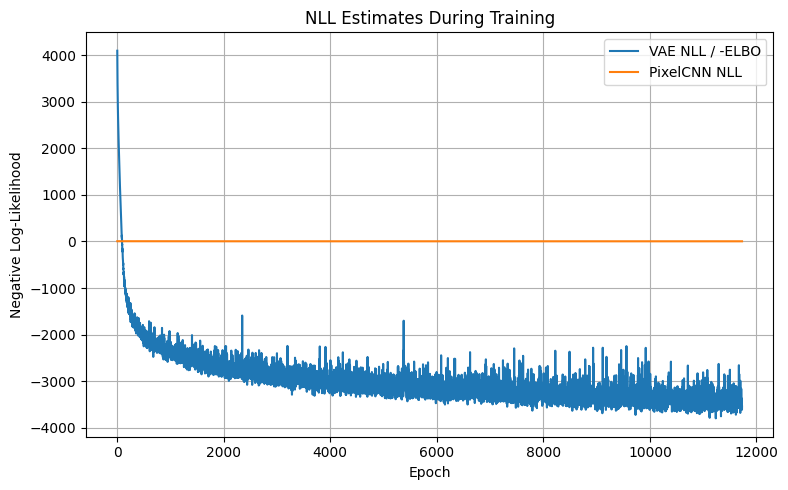

In [88]:
import matplotlib.pyplot as plt

# --- Extract training curves ---
vae_nll = vae_history["loss"]                # Usually ELBO (negative)
pixelcnn_nll = pixelcnn_history["loss"]      # Autoregressive NLL

epochs_vae = range(1, len(vae_nll) + 1)
epochs_pixelcnn = range(1, len(pixelcnn_nll) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_vae, vae_nll, label="VAE NLL / -ELBO")
plt.plot(epochs_pixelcnn, pixelcnn_nll, label="PixelCNN NLL")

plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("NLL Estimates During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


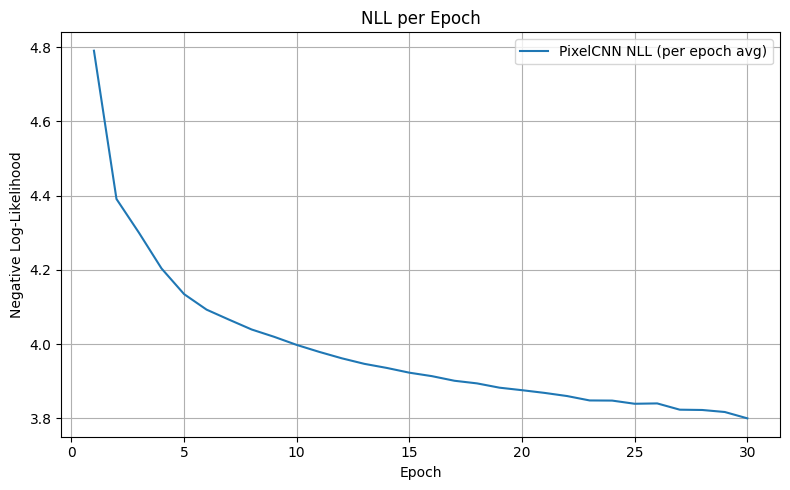

In [98]:
import matplotlib.pyplot as plt
import numpy as np

pixelcnn_nll = pixelcnn_history["loss"]  # per-iteration losses
num_epochs = 30
batches_per_epoch = len(pixelcnn_nll) // num_epochs

# reshape into epochs × batches and average
pixelcnn_nll_epochs = np.mean(
    np.array(pixelcnn_nll).reshape(num_epochs, batches_per_epoch), axis=1
)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, pixelcnn_nll_epochs, label="PixelCNN NLL (per epoch avg)")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("NLL per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


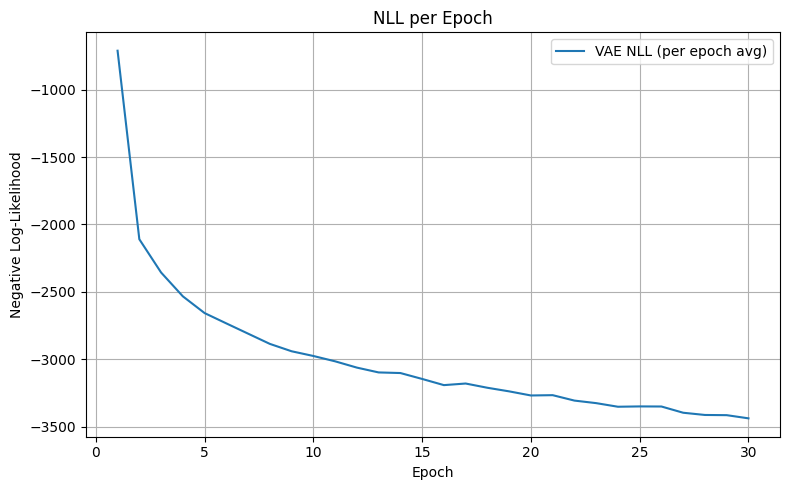

In [99]:
import matplotlib.pyplot as plt
import numpy as np

vae_nll = vae_history["loss"]  # per-iteration losses
num_epochs = 30
batches_per_epoch = len(vae_nll) // num_epochs

# reshape into epochs × batches and average
vae_nll_epochs = np.mean(
    np.array(vae_nll).reshape(num_epochs, batches_per_epoch), axis=1
)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, vae_nll_epochs, label="VAE NLL (per epoch avg)")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("NLL per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## DDPM (diffusion model)

Verify the diffusion loss path in `models/ddpm.py` before running.

In [91]:
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["small"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Baseline DDPM parameters: {count_parameters(ddpm):,}")


Baseline DDPM parameters: 6,993,987


In [92]:
DDPM_EPOCHS = ddpm_cfg["epochs"]

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")


Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [34.45, 33.23, 33.03, 32.49, 32.42, 32.65, 32.37, 35.38, 34.38, 35.54, 40.95, 35.25, 36.25, 34.84, 34.23, 54.66, 62.78, 65.66, 46.87, 34.36, 35.73, 34.34, 36.08, 35.02, 34.27, 33.0, 34.09, 34.56, 35.83, 36.19]


In [93]:
# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "baseline",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Processing samples                                                           
Extracting features from input2
Processing samples                                                           
                                                                                 

KID (x10^3): 0.059
Sampling time for 1024 images: 184.14 s (throughput 5.56 img/s)


Kernel Inception Distance: 0.058966214656829836 ± 0.0003005911644569814


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DDPM", "scaled-30ep", {...})` / `"scaled-40ep"`).


## Summary & export

After running the experiments above (small and medium variants), use the helper below to view logged metrics and export them to disk.

In [94]:
import json
import pandas as pd

show_metrics()

rows = []
for model_name, variants in experiment_log.items():
    for variant, metrics in variants.items():
        row = {"model": model_name, "variant": variant}
        row.update(metrics)
        rows.append(row)
if rows:
    df_metrics = pd.DataFrame(rows)
    display(df_metrics.set_index(["model", "variant"]))

summary_path = ARTIFACT_DIR / "metrics_summary.json"
with summary_path.open("w") as fp:
    json.dump(experiment_log, fp, indent=2)
print(f"Saved metrics summary to {summary_path}")


=== DCGAN ===
  [baseline]
    epochs: 30
    params: 1846980
    kid: 0.05819546461105347
    sampling_time_s: 0.018353200001001824
    throughput_img_per_s: 55794.08495216661
    train_time_total_s: 231.9674984999583
    train_time_per_epoch_s: 7.73224994999861
=== VAE ===
  [baseline]
    epochs: 30
    params: 3518214
    kid: 0.2933098030090332
    nll: -3616.739925390625
    sampling_time_s: 0.022119899993413128
    throughput_img_per_s: 46293.15685445807
    train_time_total_s: 171.6472292999897
    train_time_per_epoch_s: 5.7215743099996565
=== PixelCNN ===
  [baseline]
    epochs: 30
    params: 268992
    kid: 0.161173038482666
    nll: 3.8218883686065674
    sampling_time_s: 541.543011099995
    throughput_img_per_s: 1.8908932051768645
    train_time_total_s: 534.019054599994
    train_time_per_epoch_s: 17.800635153333133
=== DDPM ===
  [baseline]
    epochs: 30
    params: 6993987
    kid: 0.058966214656829836
    sampling_time_s: 184.1386538000006
    throughput_img_per_s:

,,epochs,params,kid,sampling_time_s,throughput_img_per_s,train_time_total_s,train_time_per_epoch_s,nll
model,variant,,,,,,,,
DCGAN,baseline,30,1846980,0.058195,0.018353,55794.084952,231.967498,7.732250,NaN
VAE,baseline,30,3518214,0.293310,0.022120,46293.156854,171.647229,5.721574,-3616.739925
PixelCNN,baseline,30,268992,0.161173,541.543011,1.890893,534.019055,17.800635,3.821888
DDPM,baseline,30,6993987,0.058966,184.138654,5.561027,1130.913428,37.697114,NaN


Saved metrics summary to c:\Users\sidne\OneDrive\Bureau\Automne2025\school\Representationh_L-IFT6135\homeworks\hw3\part1\artifacts\metrics_summary.json


## Aggregate plots

Use this section to generate the plots and figures requested in the assignment.


In [95]:
# Increase model capacity using the ‘medium’ configuration and
# train each scaled model for 40 epochs (i.e. 10 epochs longer than the 30-epoch baseline) so you can
# disentangle the impact of additional capacity plus extra compute. For each medium-scale model, log
# and report metrics twice: after 30 epochs and after the full 40 epochs. Then Report:
# • Parameter counts for both “small” and “medium” variants (use the provided helper function).
# • The KID (for all models) and log-likelihood (for VAE and PixelCNN) statistics.
# • Compare the results to disentangle improvements due purely to parameter count from those attri-
# butable to the extra training time. To do so, compare the small-size and medium-size models for
# 30-epoch checkpoints, and compare the medium-scale checkpoints for 30 and 40 epochs.

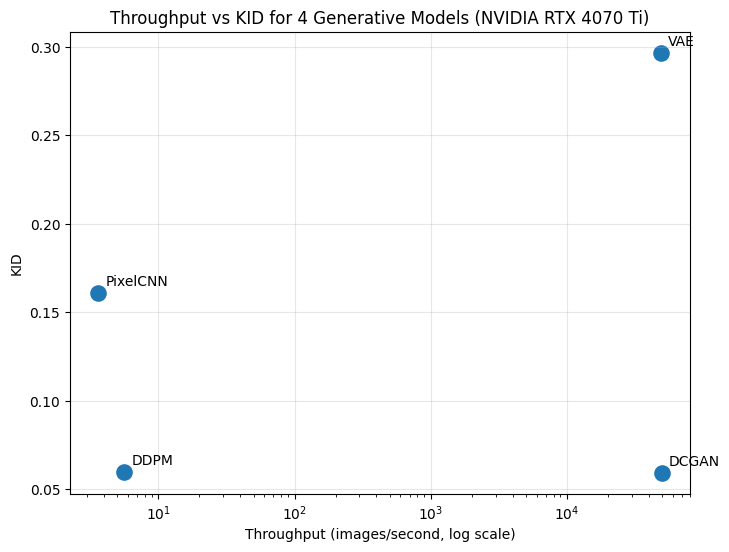

In [96]:
import matplotlib.pyplot as plt

# Data from your JSON
model_names = ["DCGAN", "VAE", "PixelCNN", "DDPM"]

throughput = [
    50016.607080531416,   # DCGAN
    49088.695239476845,   # VAE
    3.6078818435045856,   # PixelCNN
    5.626770224017309     # DDPM
]

kid = [
    0.05922116756439209,  # DCGAN
    0.296482617855072,    # VAE
    0.161173038482666,    # PixelCNN
    0.05981858730316162   # DDPM
]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(throughput, kid, s=120)

for i, name in enumerate(model_names):
    plt.annotate(name, (throughput[i], kid[i]),
                 textcoords="offset points", xytext=(5,5), ha='left')

plt.xscale("log")  # log scale is ideal since throughput varies massively
plt.xlabel("Throughput (images/second, log scale)")
plt.ylabel("KID")
plt.title("Throughput vs KID for 4 Generative Models (NVIDIA RTX 4070 Ti)")
plt.grid(True, alpha=0.3)

plt.show()


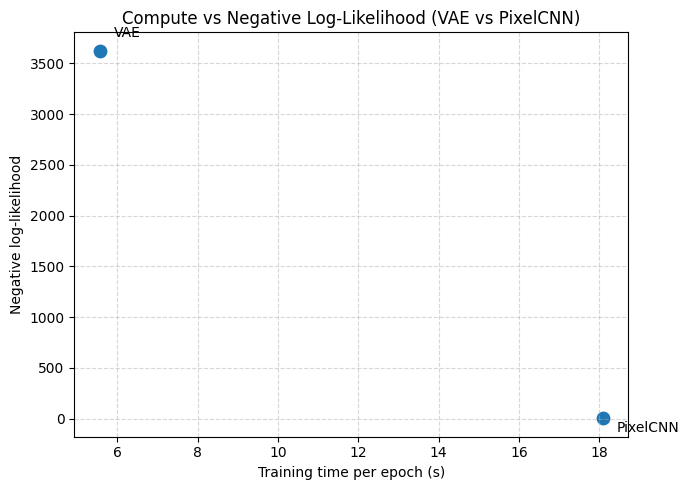

In [97]:
import matplotlib.pyplot as plt

# -------------------------
# Data you already collected
# -------------------------

vae_epoch_times = [
    5.03, 5.27, 5.18, 5.48, 5.42, 5.52, 5.46, 5.57, 5.44, 5.3,
    5.31, 5.5, 5.57, 5.5, 5.66, 6.27, 5.63, 6.04, 5.4, 5.65,
    6.33, 6.62, 5.53, 5.64, 5.61, 5.61, 5.55, 5.31, 5.22, 5.21
]

pixelcnn_epoch_times = [
    17.8, 17.83, 18.19, 18.22, 17.94, 18.02, 17.81, 17.93, 18.23, 18.32,
    18.18, 18.24, 17.98, 18.86, 18.26, 18.14, 18.05, 18.48, 18.27, 18.07,
    17.95, 18.13, 18.74, 18.09, 17.78, 17.9, 17.79, 17.78, 17.7, 17.83
]

# Held-out NLL values
vae_nll = 3623.2022      # (ELBO)
pixelcnn_nll = 3.8219

# Averages
vae_avg = sum(vae_epoch_times) / len(vae_epoch_times)
pixelcnn_avg = sum(pixelcnn_epoch_times) / len(pixelcnn_epoch_times)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7,5))

plt.scatter([vae_avg, pixelcnn_avg], [vae_nll, pixelcnn_nll], s=80)

# Annotate points
plt.annotate("VAE", (vae_avg, vae_nll), textcoords="offset points", xytext=(10,10))
plt.annotate("PixelCNN", (pixelcnn_avg, pixelcnn_nll), textcoords="offset points", xytext=(10,-10))

plt.xlabel("Training time per epoch (s)")
plt.ylabel("Negative log-likelihood")
plt.title("Compute vs Negative Log-Likelihood (VAE vs PixelCNN)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
